<a href="https://colab.research.google.com/github/cehkop/MSU_AI-v5/blob/main/L06_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <font size="6">Сверточные нейронные сети</font>

# Введение в сверточные нейронные сети

## Полносвязная нейронная сеть

Fully-connected Neural Network (FCN). В современных статьях чаще используется термин Multi-Layer Perceptron (MLP).

На прошлом занятии мы научились строить сети из нескольких слоев.

Вспомним как мы это делали:

1. Превращаем исходные данные в вектор.

>***Примечание***: Для цветного изображения из CIFAR-10 размером $32\times32$ пикселя ($32\times32\times3$) размерность входного вектора будет равна $3072$.

2. Перемножаем матрицу данных с матрицей весов. Размер последней может быть, например, $100\times3072$. Где $3072$ &mdash; размер входного вектора, а $100$ &mdash; количество признаков, которое мы хотим получить. Результат обработки одного входа будет иметь размер $100\times1$.

3. Поэлементно применяем к вектору признаков нелинейную функцию (функцию активации), например, Sigmoid или ReLU. Размерность данных при этом не меняется ($100\times1$). В результате получаем вектор активаций.

4. Используем полученные активации как входные данные для нового слоя. Количество весов слоя будет зависеть от размерности входной матрицы и того, что мы хотим получить на выходе. Если мы делаем классификатор на $10$ классов, то матрица весов должна иметь размерность $10\times100$, и на этом можно остановиться. Но в общем случае количество слоев может быть произвольным.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/modified_model.png" width="600">

$ \large h=W_1 \times x$

$ \large S=W_2 \times f(h)=W_2 \times f(W_1 \times x)$

На изображении представлена описанная выше нейронная сеть, функцией активации в которой является ReLU. Добавление второго слоя позволило модели использовать более одного шаблона на класс. Можно убедиться в этом, обучив модель на датасете CIFAR-10 и визуализировав веса первого слоя модели.

In [ ]:
from torch import nn


class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.layers_stack(x)

Скачаем файл с предобученными весами (точность ~ 0.5)

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/weights/2layer.pt'

Загрузим веса в модель:

In [ ]:
import torch

fc_model = FCNet()
weights_in_dict = torch.load("2layer.pt")
fc_model.load_state_dict(weights_in_dict)

<All keys matched successfully>

**MLP: Набор шаблонов классов, выученных нейросетью**

Визуализируем веса первого слоя

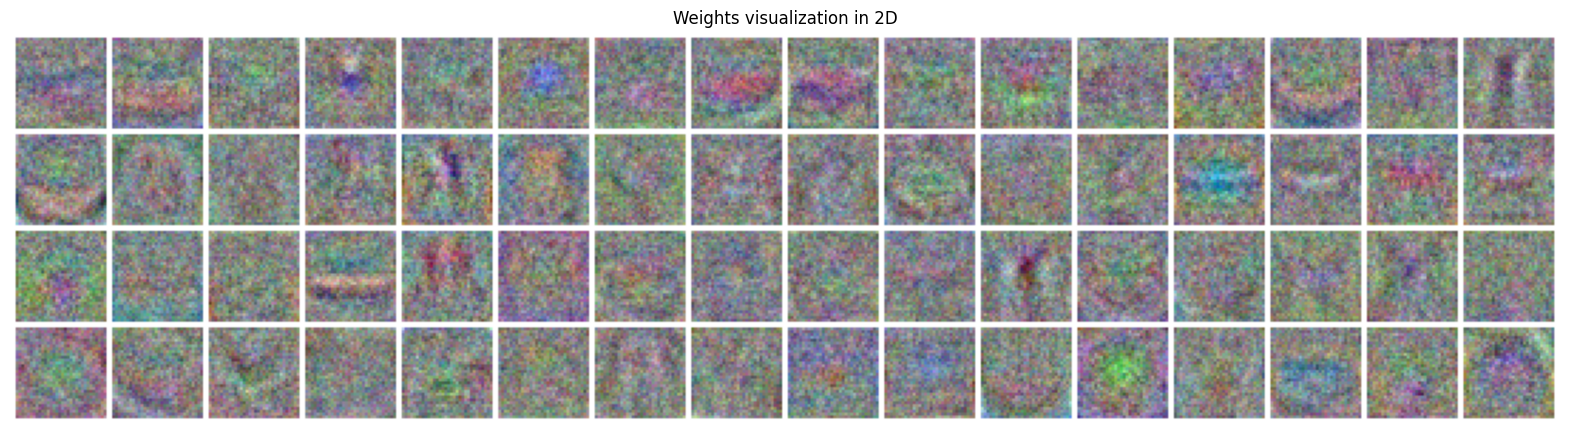

In [ ]:
from torchvision import utils
import matplotlib.pyplot as plt


W1 = fc_model.layers_stack[0].weight.reshape(64, 3, 32, 32)  # layer has 64 neurons
img_grid = utils.make_grid(W1, pad_value=1, normalize=True, nrow=16)

plt.figure(figsize=(20, 12))
plt.title("Weights visualization in 2D")
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())  # CHW -> HWC
plt.axis("off")
plt.show()

За счёт создания нескольких шаблонов для каждого из классов, многослойные архитектуры в общем случае показывают более высокую, чем перцептроны, эффективность на задачах классификации изображений. Однако подход с использованием многослойного перцептрона также имеет свои недостатки:

## Нарушение связей между соседними пикселями

При вытягивании изображения в вектор мы теряем информацию о взаимном расположении пикселей на исходной картинке.





 <img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/img_to_vector_problem.png" width="700">

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/L06/digit.png'

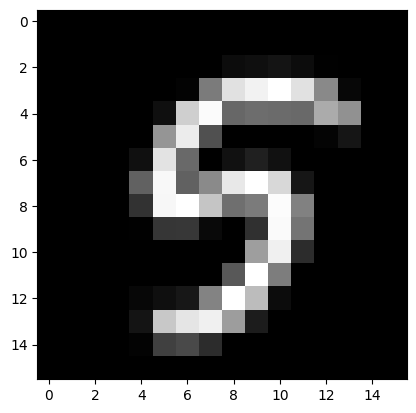

In [ ]:
import numpy as np
from PIL import Image


image = Image.open("digit.png")
img_np = np.array(image)
plt.imshow(img_np, cmap="gray")
plt.show()

In [ ]:
print(img_np)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  12  15  20  12   1   0   0   0]
 [  0   0   0   0   0   0   3 123 225 242 255 225 137   7   0   0]
 [  0   0   0   0   0  15 207 251 103 109 107 105 171 145   0   0]
 [  0   0   0   0   0 149 236  80   0   0   0   0   4  21   0   0]
 [  0   0   0   0  16 228 106   0  17  33  17   0   0   0   0   0]
 [  0   0   0   0  97 248  98 138 232 255 216  22   0   0   0   0]
 [  0   0   0   0  50 247 255 197 111 123 252 129   0   0   0   0]
 [  0   0   0   0   1  54  55   9   0  49 250 116   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 158 240  44   0   0   0   0]
 [  0   0   0   0   0   0   0   0  88 255 125   0   0   0   0   0]
 [  0   0   0   0   7  15  23 132 255 188  12   0   0   0   0   0]
 [  0   0   0   0  20 200 229 240 157  28   0   0   0   0   0   0]
 [  0   0   0   0   3  64  73  45   0   0   0   0   0   0   0 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 15, 20, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 123, 225, 242, 255, 225, 137, 7, 0, 0, 0, 0, 0, 0, 0, 15, 207, 251, 103, 109, 107, 105, 171, 145, 0, 0, 0, 0, 0, 0, 0, 149, 236, 80, 0, 0, 0, 0, 4, 21, 0, 0, 0, 0, 0, 0, 16, 228, 106, 0, 17, 33, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 248, 98, 138, 232, 255, 216, 22, 0, 0, 0, 0, 0, 0, 0, 0, 50, 247, 255, 197, 111, 123, 252, 129, 0, 0, 0, 0, 0, 0, 0, 0, 1, 54, 55, 9, 0, 49, 250, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 240, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 255, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 15, 23, 132, 255, 188, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 200, 229, 240, 157, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 64, 73, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


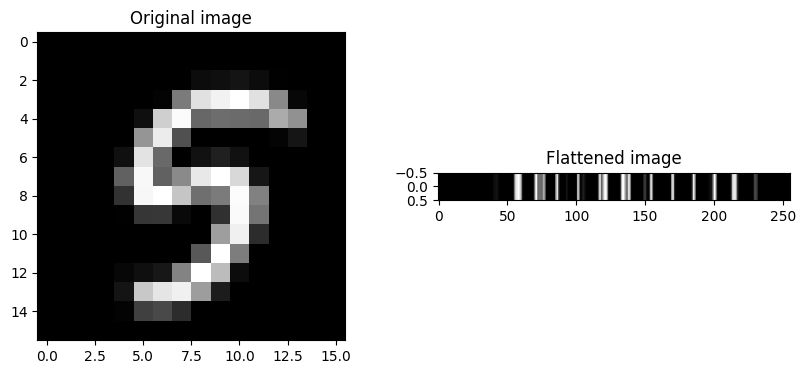

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].imshow(img_np, cmap="gray")
ax[1].imshow(img_np.reshape(1, -1), aspect=20, cmap="gray")
ax[0].set_title("Original image")
ax[1].set_title("Flattened image")

vector = np.array(image).flatten()
print(list(vector))

Пиксели, которые были соседними и составляли цельный объект, могут оказаться на большом расстоянии внутри результирующего вектора. Получается, что мы просто удалили информацию об их близости, важность которой нам как людям очевидна.

Идея полносвязной нейронной сети пришла к нам из математической модели восприятия информации мозгом ([перцептрон Розенблатта](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D0%B5%D1%80%D1%81%D0%B5%D0%BF%D1%82%D1%80%D0%BE%D0%BD)). Возможно, чтобы получить хорошие результаты при обработке изображений, нужно посмотреть, как работает человеческий глаз?


### Рецептивное поле

В нашей полносвязной сети каждый нейрон "видит" сразу все изображение (все данные). Наша зрительная система работает иначе.

*  Каждый фоторецептор на сетчатке нашего глаза (палочка или колбочка) реагирует только на свет, попавший на него.

* Сигнал от фоторецептора попадает на нейрон следующего уровня ([биполярная клетка](https://ru.wikipedia.org/wiki/%D0%91%D0%B8%D0%BF%D0%BE%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%B5_%D0%BA%D0%BB%D0%B5%D1%82%D0%BA%D0%B8_%D1%81%D0%B5%D1%82%D1%87%D0%B0%D1%82%D0%BA%D0%B8)). Этот нейрон уже соединен с несколькими фоторецепторами. Область, в которой они локализованы, называется **рецептивным полем**.
Нейрон возбуждается при определенной комбинации сигналов от связанных с ним рецепторных клеток. По сути, он реагирует на простой, локально расположенный паттерн.

* Клетки уровнем выше (ганглиозные) собирают информацию с нескольких близко расположенных биполярных клеток и активируются при уникальной комбинации сигналов с них. Их рецептивное поле больше, и паттерны, на которые они реагируют, сложнее.






**Рецептивное поле** нейрона — это участок с рецепторами, с которых он прямо или опосредованно, через другие нейроны, получает информацию.



<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/brain.png" width="1000">

* Далее сигнал предается в мозг, но там связи между нейронами продолжают оставаться иерархическими. Рецептивное поле нейронов растет, и паттерны, на которые они активируются, становятся все более и более сложными.

### Скользящее окно (фильтр)

Получается, что можно не подавать на вход нейрона первого слоя информацию о всем изображении сразу, а "показать" ему только часть картинки. Чтобы он научился распознавать простые, но универсальные паттерны. А их агрегация произойдет в последующих слоях.

Для этого используется так называемое "скользящее окно", которое двигается по изображению, захватывая на каждом шаге только небольшу область.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/convolution_with_filter.gif" width="500">

Такой подход используют, например, при наложении графических **фильтров**. Вы наверняка пользовались ими, если работали в графических редакторах, например, в Photoshop.



### Фильтр Гаусса

Посмотрим, как можно реализовать такой фильтр на примере фильтра Гаусса размером $3 \times 3$ для размытия изображения.

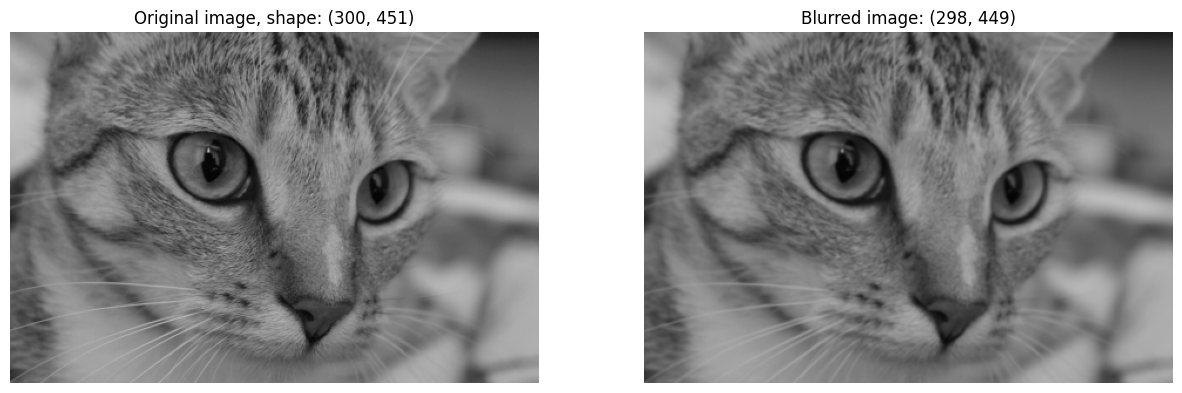

In [ ]:
from skimage import data


# fmt: off
# Gaussian 3x3 kernel, sum of weights == 1
kernel = np.array([[1/16, 1/8, 1/16],
                   [1/8,  1/4, 1/8 ],
                   [1/16, 1/8, 1/16]])
# fmt: on


def apply_filter(img, kernel):
    h, w = np.array(img.shape)  # image height and width
    kh, kw = np.array(kernel.shape)  # kernel height and width (3x3)
    # calculate the output size, hard work ...
    out = np.zeros((h - kh + 1, w - kw + 1))
    for i in range(h - kh + 1):
        for j in range(w - kw + 1):
            # get 3x3 patch from image
            patch = img[i : i + kh, j : j + kw]
            # elementwise multiply patch pixels to kernel weights and sum
            new_pixel = np.multiply(patch, kernel).sum()
            # store modified pixel in new blurred image
            out[i, j] = new_pixel
    return out


img_cat = data.cat().mean(axis=2).astype("int32")
out = apply_filter(img_cat, kernel)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img_cat, cmap="gray", vmin=0, vmax=255)
axes[1].imshow(out, cmap="gray", vmin=0, vmax=255)
axes[0].set(title=f"Original image, shape: {img_cat.shape}")
axes[1].set(title=f"Blurred image: {out.shape}")
axes[0].axis("off")
axes[1].axis("off")
plt.show()

Последовательность действий:

*  Для каждого пикселя исходного изображения берем окрестность размером $3 \times 3$.
*  Значение каждого пикселя из этой окресности умножаем на соответствующее значение из массива kernel (тоже $3 \times 3$).
*  Затем суммируем все 9 результатов, получившееся число записываем в новый массив.
* В результате получаем сглаженное изображение.

Таким образом, для получения нового изображения мы применили формулу:

$output(x,y) =  \sum_{i}^{H} \sum_{j}^{W}k_c[i,j] I_c[x+j,y+i]$

 $H, W$ — высота и ширина ядра фильтра,

 $I$ — исходное изображение.


**Если бы мы вытягивали фрагменты картинки и ядро фильтра в вектора, затем их скалярно пермножили, результат был бы тем же!**


## Другие 'hand-crafted' фильтры

Такой же алгоритм можно применять не для сглаживания изображения, а для поиска (выделения) на нем чего-либо: например, контуров объектов. Для этого достаточно заменить ядро фильтра.

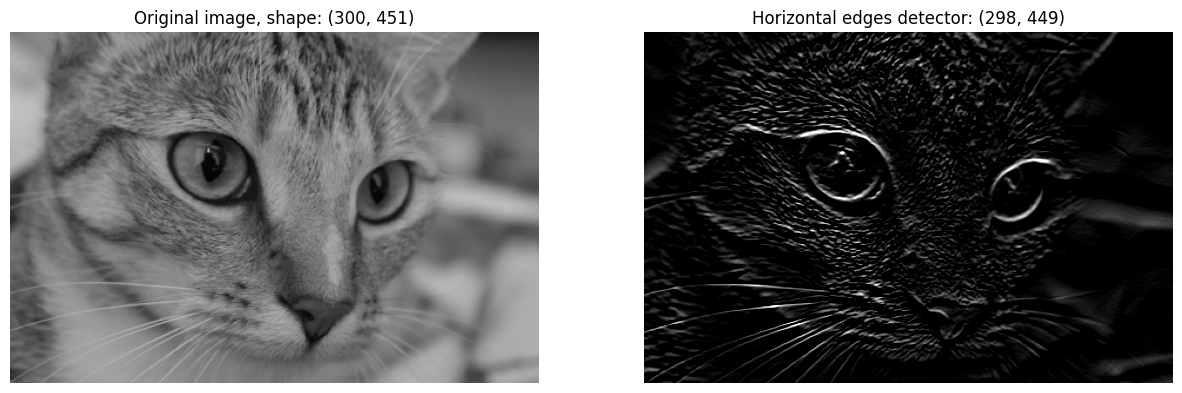

In [ ]:
# fmt: off
sobel_y_kernel = torch.tensor([[ 1.0,  2.0, 1.0 ],
                               [ 0.0,  0.0, 0.0 ],
                               [-1.0, -2.0, -1.0]])
# fmt: on

x_edges = apply_filter(img_cat, sobel_y_kernel)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img_cat, cmap="gray", vmin=0, vmax=255)
axes[1].imshow(x_edges, cmap="gray", vmin=0, vmax=255)
axes[0].set(title=f"Original image, shape: {img_cat.shape}")
axes[1].set(title=f"Horizontal edges detector: {out.shape}")
axes[0].axis("off")
axes[1].axis("off")
plt.show()

Мы применили к изображению [фильтр Cобеля](https://en.wikipedia.org/wiki/Sobel_operator), а точнее, одно из его ядер, дающее отклик на перепад яркости по вертикали.

"Отклик" — это величина яркости, которую мы получили на результирующем изображении.

Можно запрограммировать свой фильтр, который будет искать произвольный объект.
Например, найдем крест на на изображении:

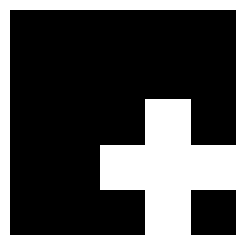

In [ ]:
# fmt: off
cross = np.array([[0, 0 ,0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 0]])
# fmt: on

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.axis("off")
plt.show()

Для этого создадим фильтр размером с объект ($3 \times 3$). В точках, где должны быть пиксели, принадлежащие объекту, поместим положительные значения, а там, где должен быть фон — отрицательные.



In [ ]:
# fmt: off

kernel_cs = np.array([[-1, 1, -1],
                      [ 1, 1,  1],
                      [-1, 1, -1]])
# fmt: on

При попадании такого фильтра на объект отрицательные значения обнулятся при перемножении с пикселями фона, а положительные — просуммируются и дадут высокий отклик.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/cross_filter.png" width="900">


Проверим :

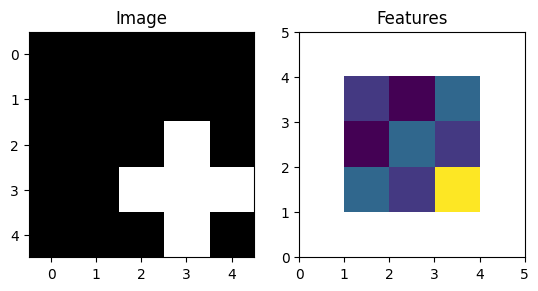

Features:
 [[ 0. -1.  1.]
 [-1.  1.  0.]
 [ 1.  0.  5.]]


In [ ]:
features = apply_filter(cross, kernel_cs)

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.imshow(features, extent=(1, 4, 1, 4))
plt.title("Features")

plt.show()
print("Features:\n", features)

Такого рода фильтров люди придумали довольно много. Есть [детектор углов Харриса](https://en.wikipedia.org/wiki/Harris_Corner_Detector) или [признаки Хаара](https://en.wikipedia.org/wiki/Haar-like_feature), которые успешно использовались для [обнаружения лиц](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) на фотографиях. Это примеры случаев, когда людям удалось подобрать удачные ядра фильтров для решения конкретных задач.

Мы хотим, чтобы модель могла обучаться решать различные задачи. И вместо того, чтобы вручную создавать фильтры, мы будем подбирать их значения *в процессе обучения*.

## Свертка с фильтром

Операцию применения фильтра к изображению будем называть *сверткой*. Это определение не вполне соответствует [математическому](https://en.wikipedia.org/wiki/Convolution), но повсеместно используется в DL.

По своей сути операция свёртки — это та же самая взвешенная сумма с добавлением свободного члена, используемая в полносвязных линейных слоях.

В фильтрах Собеля и Гаусса свободный член осутствовал. Но в дальнейшем мы будем его использовать.

Давайте выполним свертку при помощи помощи линейного слоя: заменим код внутри цикла линейным слоем и убедимся, что результат вычислений не поменялся.



In [ ]:
local_linear = nn.Linear(9, 1, bias=False)  # 9 = 3 * 3 (weights shape: (3,3))

local_linear.weight.data[0] = torch.tensor(kernel_cs).flatten()  # Bad practice
cross_in_tensor = torch.tensor(cross).float()
result = torch.zeros((3, 3))
for i in range(0, result.shape[0]):
    for j in range(0, result.shape[1]):
        segment = cross_in_tensor[i : i + 3, j : j + 3].flatten()
        result[i, j] = local_linear(segment)

print(f"result:\n{result}")

result:
tensor([[ 0., -1.,  1.],
        [-1.,  1.,  0.],
        [ 1.,  0.,  5.]], grad_fn=<CopySlices>)


Ключевое отличие между линейным слоем и свёрткой заключается в том, что каждый нейрон линейного слойя получает на вход всё изображение сразу, а свёртка &mdash; небольшие фрагменты.

Так как при свертке для каждого фрагмента получаем свой отклик (признак), то для всего изображения получим уже массив признаков (feature map).




<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/neuron_output.png" width="600">

# Сверточный слой нейросети

В PyTorch есть класс [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), который реализует операцию свертки для целого изображения.


In [ ]:
import torch
import numpy as np

# fmt: off
cross = np.array([[0, 0 ,0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 0]])

kernel_cs = np.array([[-1, 1, -1],
                      [ 1, 1,  1],
                      [-1, 1, -1]])
# fmt: on

cross_in_tensor = torch.tensor(cross).float()

In [ ]:
from torch.nn import Conv2d

conv = Conv2d(
    in_channels=1,  # what's this ?
    out_channels=1,  # what's this ?
    kernel_size=(3, 3),  # kernel.shape == 3x3
    bias=False,
)
# conv2d accepts input of shape BxCxHxW
feature_map = conv(
    cross_in_tensor.unsqueeze(0).unsqueeze(0)
)  # add batch and channel dim
print(feature_map)

tensor([[[[ 0.0000, -0.0932,  0.1402],
          [-0.0932,  0.2275, -0.1260],
          [ 0.1806, -0.2565, -0.4457]]]], grad_fn=<ConvolutionBackward0>)


Так как изначально ядро нашего единственного фильтра (нейрона) инициализированно случайными небольшими значениями, то на выходе получается набор ничего не значащих чисел. Убедимся, что слой работает так, как мы ожидали, подменив ядро:

In [ ]:
# data[0] because filter can have multiple kernels. see next chapter
conv.weight.data[0] = torch.tensor(kernel_cs)  # replace original kernel

feature_map = conv(
    cross_in_tensor.unsqueeze(0).unsqueeze(0)
)  # add batch and channel dim
print("Feature map for cross\n", feature_map)

Feature map for cross
 tensor([[[[ 0., -1.,  1.],
          [-1.,  1.,  0.],
          [ 1.,  0.,  5.]]]], grad_fn=<ConvolutionBackward0>)


При создании экземпляра объекта класса [nn.Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) помимо размера ядра (`kernel_size`), мы передали в конструктор еще два параметра:

`in_channels = 1 ` и `out_channels = 1`

Разберемся что они означают.

### Обработка цветных/многоканальных изображений

`in_channel` — это количество каналов входного тензора (изображения).

В примерах выше мы рассматривали [черно-белые](https://ru.wikipedia.org/wiki/%D0%A7%D1%91%D1%80%D0%BD%D0%BE-%D0%B1%D0%B5%D0%BB%D0%B0%D1%8F_%D1%84%D0%BE%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D1%84%D0%B8%D1%8F) изображения. Их также называют одноканальными изображениями, т. к. в них цвет пикселя определяется одним числом, характеризующим яркость.

Хранятся они в двумерном массиве размером $[H,W]$. Цветные изображения хранятся в трехмерных массивах $[H,W,C]$ или $[C,W,H]$ где $C$ — количество цветовых каналов. Для RGB изображений $C=3$. Так как `Conv2d` рассчитан на работу с многоканальным входом, то в коде выше нам пришлось написать дополнительный `unsqueeze(0)`, чтобы добавить к тензору с изображением это 3-е измерение.

Важно, что для каждого канала будет создано дополнительное ядро фильтра.


In [ ]:
conv_ch1 = Conv2d(in_channels=1, out_channels=1, kernel_size=5)
print("One channel kernel \t", conv_ch1.weight.shape)
conv_ch3 = Conv2d(in_channels=3, out_channels=1, kernel_size=5)
print("Three channel kernel \t", conv_ch3.weight.shape)

One channel kernel 	 torch.Size([1, 1, 5, 5])
Three channel kernel 	 torch.Size([1, 3, 5, 5])


Опробуем трехканальную свертку на цветном изображении:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/L06/cat.jpg

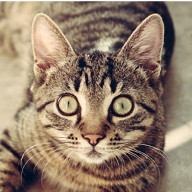

In [ ]:
from PIL import Image

cat_in_pil = Image.open("cat.jpg")
display(cat_in_pil)

Изображение из формата Pillow надо превратить в torch.Tensor

In [ ]:
cat_in_np = np.array(cat_in_pil)  # pillow -> numpy
cat_in_float = cat_in_np.astype(np.float32) / 255  # int->float
cat_in_tensor = torch.tensor(cat_in_float)  # np -> torch

try:
    conv_ch3(cat_in_tensor.unsqueeze(0))  # add batch dimension
except Exception as e:
    print("Error: \n", e)

Error: 
 Given groups=1, weight of size [1, 3, 5, 5], expected input[1, 192, 192, 3] to have 3 channels, but got 192 channels instead


Получим ошибку, связанную с количеством каналов. Дело в том, что в PyTorch, в отличие от OpenCV, TensorFlow и ряда других библиотек, каналы (RGB) идут в первом, а не в последнем измерении тензора, описывающего картинку.

OpenCV, TensorFlow, Pillow, etc. : `Batch x Height x Width x Channels`

PyTorch : `Batch x Channels x Height x Width`



Придется сделать дополнительное преобразование, чтобы каналы оказались на том месте, где их ожидает PyTorch

In [ ]:
print("Original \t", cat_in_tensor.shape, "HWC")
cat_in_tensor_channel_first = cat_in_tensor.permute(2, 0, 1)  # HWC -> CHW
print("Torch style \t", cat_in_tensor_channel_first.shape, "CHW")

Original 	 torch.Size([192, 192, 3]) HWC
Torch style 	 torch.Size([3, 192, 192]) CHW


Теперь можно подать изображение на вход модели, предварительно добавив batch-размерность

In [ ]:
one_image_batch = cat_in_tensor_channel_first.unsqueeze(0)
out = conv_ch3(one_image_batch)
print("No error!")

No error!


Нет необходимости проделывать все эти манипуляции вручную, так как в torchvision реализованы класс [`ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html?highlight=totensor#torchvision.transforms.ToTensor) и функция [`to_tensor`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_tensor.html), которые выполняют эти преобразования.

Убедимся, что тензор, преобразованный нами вручную, и тензор, получившийся после применения функции [`to_tensor`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_tensor.html), совпали:


In [ ]:
from torchvision.transforms.functional import to_tensor

cat_in_tensor2 = to_tensor(cat_in_pil)
print(cat_in_tensor2.shape)

print(
    "Tensor almost equal: ",
    torch.allclose(cat_in_tensor_channel_first, cat_in_tensor2),  # float comparsion
)

torch.Size([3, 192, 192])
Tensor almost equal:  True


Теперь посмотрим на форму выхода (который мы получили ячейкой выше):

In [ ]:
print("Output feature map size:", out.shape)  # first dim is batch

Output feature map size: torch.Size([1, 1, 188, 188])


Такую размерность имеет выход  **единственного нейрона** в нашем сверточном слое.

На входе несколько каналов (3), на выходе остался один канал.
Как же комбинируются результаты сверток в разных каналах?



<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/convolution_rgb.png" width="700">


Результаты сверток всех ядер фильтра с соответствующими входными каналами просто суммируются:

$feature\_map(x,y) = \sum_{c}^{C} \sum_{i}^{H} \sum_{j}^{W}k_c[i,j]I_c[x+j,y+i] +bias$

$C$ — количество каналов,

$H, W$ — высота и ширина ядра фильтра,

$K_c$ — ядро для канала $с$,

$I$ — изображение (массив $СxHxW$),

$I_c$ — канал изображения номер $с$ (срез массива $I$, соответствующий каналу изображения номер c).

В силу коммутативности суммы не важно, в каком порядке будут складываться элементы. Можно считать, что каждый элемент входа сначала умножается на свой коэффициент из ядра, а уже затем все суммируется.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/rgb_image_convolution_filter.png" width = "650">

Так выглядит выход одного нейрона, который задается несколькими ядрами и  смещением (bias).

При этом bias  **один** на весь фильтр.

In [ ]:
print("Kernels", conv_ch3.weight.shape)
print("Biases", conv_ch3.bias.shape)

Kernels torch.Size([1, 3, 5, 5])
Biases torch.Size([1])


Входные данные не всегда будут трехканальными цветными [RGB](https://ru.wikipedia.org/wiki/RGB)-изображениями, в которых цвет пикселя определяется тремя числами, характеризующими три основных цвета (красный, зеленый и синий).

Входной тензор может иметь произвольное количество каналов. Например: марсоход Opportunity для получения изображений использовал [13 каналов](https://habr.com/ru/post/160621/).

Более того, в качестве входного тензора можно использовать не изображение, а **карту активаций** предыдущего сверточного слоя.


### Использование нескольких фильтров

Возвращаемся ко второму параметру конструктора `nn.Conv2D` —
`out_channels = 1`

Этот параметр задает количество фильтров слоя.

In [ ]:
conv35 = Conv2d(in_channels=3, out_channels=5, kernel_size=3)
out = conv35(cat_in_tensor_channel_first)

print(f"weights shape: {conv35.weight.shape}")  # 5 filters 3x3x3
print(f"weights shape: {conv35.bias.shape}")  # one bias per filter

weights shape: torch.Size([5, 3, 3, 3])
weights shape: torch.Size([5])


В линейном слое каждый нейрон учился активироваться на некий шаблон, например, красную машину или смотрящую направо лошадь.

Мы хотим, чтобы нейроны сверточного слоя так же активировались на различные паттерны (например, ухо, нос, глаз и т.д.). Для каждого паттерна нам нужен свой нейрон $⇒$ свой фильтр.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/neuron_is_filter.png" width="600">

 Каждый нейрон сформирует свою карту признаков, размером $1\times H_{out}\times W_{out}$. А на выходе слоя будет их конкатенация:

In [ ]:
print(f"result shape: {out.shape}")  # 5 feature map

result shape: torch.Size([5, 190, 190])


 При объединении этих карт получится тензор размерности $C_{out}\times H_{out} \times W_{out}$, где $C_{out}$ — количество фильтров.

На изображении ниже продемонстрирован результат применения сверточного слоя,
содержащего $5$ фильтров, к изображению из CIFAR-10.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/convolution_layer_with_5_filters.png" width="400">

Стоит отметить, что, в отличие от полносвязного слоя, свёрточный слой не требует информации о количестве значений во входном представлении и может быть использован как для представлений $C_{in} \times 32 \times 32$, так и $C_{in} \times 100 \times 100$. Словом, представления могут иметь практически любой размер, главное, чтобы пространственные размеры не были меньше размеров ядра свёртки.



### Уменьшение размера карты признаков

Карта признаков после применения функции активации может быть передана на вход следующей операции свёртки.

In [ ]:
from torch.nn.functional import relu

conv_1 = torch.nn.Conv2d(
    in_channels=3,  # Number of input channels (3 for RGB images)
    out_channels=6,  # Number of filters/output channels
    kernel_size=5,
)

conv_2 = torch.nn.Conv2d(
    in_channels=6,  # Number of input channels (3 for RGB images)
    out_channels=10,  # Number of filters/output channels
    kernel_size=5,
)

img = torch.randn((1, 3, 32, 32))  # 1-batch size, 3-num of channels, (32,32)-img size
print(f"img shape: {img.shape}")

out_1 = conv_1(img)
print(f"out_1 shape: {out_1.shape}")  # [1, 6, 28, 28]

out_2 = conv_2(relu(out_1))
print(f"out_2 shape: {out_2.shape}")  # [1, 10, 24, 24]

img shape: torch.Size([1, 3, 32, 32])
out_1 shape: torch.Size([1, 6, 28, 28])
out_2 shape: torch.Size([1, 10, 24, 24])


Заметим, что после свёртки ширина $W_{out}$ и высота $H_{out}$ **карты признаков** будут отличаться от **пространственных размерностей** $W_{in}$ и $H_{in}$ исходного тензора. К примеру, при обработке трёхканального тензора размера $32 \times 32$ ядром размера $5 \times 5$, можно будет произвести лишь $27$ сдвигов $(32 - 5)$ по вертикали и столько же по горизонтали. Но при этом размер итоговой карты признаков будет равен $28 \times 28$, поскольку первый ряд (либо столбец) можно получить без сдвигов по вертикали либо горизонтали, соответственно. При повторном применении фильтра размер каждой из сторон уменьшится ещё на $4$.

Итоговое значение $N'$ пространственной размерности $N$ для квадратного фильтра $K \times K$ фильтра $F$ вычисляется по следующей формуле: $$\large N' = N - K + 1$$.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/decrease_size_of_image_after_convolution.png" width="700">

Заметим, что при уменьшении размера представлений, пиксели, находящиеся около краёв, участвуют в значительно меньшем количестве свёрток, чем пиксели в середине, хотя информация в них не обязательно менее ценна, чем информация из центральных пикселей. К примеру, пиксель в верхнем левом углу представления вне зависимости от размера фильтра будет принимать участие лишь в одной свёртке, и информация о нём будет сохранена лишь в верхнем левом углу нового представления.

### Расширение (padding)

Для борьбы с описанной выше проблемой применяется *набивка/дополнение* входного тензора (англ. *padding*). В ходе него ширина и высота тензора увеличиваются за счёт приписывания столбцов и строк с некими значениями. К примеру, на изображении ниже перед свёрткой ядром размера $3\times3$ был применён padding нулями.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/padding.png" width="250">

На примере убедимся, что это позволит нам сохранить пространственные размерности тензоров.

In [ ]:
img = torch.randn((1, 1, 5, 5))  # create random image BCHW
print(f"Original tensor:\nshape:{img.shape}")
conv_3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conved_3 = conv_3(img)
print("Shape after convolution layer(kernel 3x3):", conved_3.shape)

Original tensor:
shape:torch.Size([1, 1, 5, 5])
Shape after convolution layer(kernel 3x3): torch.Size([1, 1, 3, 3])


Карта признаков меньше чем вход. Теперь добавим padding:

In [ ]:
# add zeros to image manually
padded_img = torch.zeros((1, 1, 7, 7))  # create zeros array to insert image in center
padded_img[:, :, 1:-1, 1:-1] += img  # insert image, we get image arounded by zeros
print(f"\nPadded tensor:\nshape:{padded_img.shape}:\n {padded_img}")

conved_pad_3 = conv_3(padded_img)
print("\n\nPadded shape:", padded_img.shape)
print("Shape after convolution with padding(kernel 3x3):", conved_pad_3.shape)


Padded tensor:
shape:torch.Size([1, 1, 7, 7]):
 tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000, -2.0802, -0.7086,  1.3109,  1.2287,  0.7773,  0.0000],
          [ 0.0000, -1.0442,  0.9661, -0.1871,  0.4678, -0.3011,  0.0000],
          [ 0.0000,  1.5798,  0.2614, -0.6161, -0.2201, -0.8289,  0.0000],
          [ 0.0000, -0.3213, -1.7980,  2.3900,  0.1072,  0.8938,  0.0000],
          [ 0.0000,  0.8068, -1.4594, -1.5094,  0.9208, -0.9101,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]]])


Padded shape: torch.Size([1, 1, 7, 7])
Shape after convolution with padding(kernel 3x3): torch.Size([1, 1, 5, 5])


Размер выхода равен размеру входа.

Однако если мы увеличим размер ядра до 5x5, то увидим, что, несмотря на padding, выход снова стал меньше входа:

In [ ]:
conv_5 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

conved_pad_5 = conv_5(padded_img)

print("\n\nOriginal shape:", img.shape)
print("Shape after convolution with padding(kernel 5x5):", conved_pad_5.shape)



Original shape: torch.Size([1, 1, 5, 5])
Shape after convolution with padding(kernel 5x5): torch.Size([1, 1, 3, 3])


Дополнение одним рядом и одним столбцом не является универсальным решением: для фильтра размером 5 размер выходного тензора всё равно отличается от входного. Если мы немного видоизменим полученную выше формулу (используя размер дополнения $P$), то получим : $N' = N + 2\cdot P - K + 1$.
Для того, чтобы пространственные размеры не изменялись ($N' = N$), для разных размеров фильтра требуются разные размеры паддинга. В общем случае для размера фильтра $F$ требуемый размер дополнения:  $$\displaystyle P = \frac{K-1}{2}$$




Теперь реализуем padding, используя инструменты библиотеки PyTorch, и сравним его с ручным добавлением padding:

In [ ]:
# conv layer without padding (padding=0 by default)
conv_3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)

# conv layer with padding = 1 (add zeros)
conv_3_padded = torch.nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=3, padding=1
)  # Padding added 1 zeros line to all four sides of the input
original = conv_3(padded_img)
padded = conv_3_padded(img)

print(f"Explicitly padded:\n{original.shape}")
print(f"\nImplicitly padded:\n{padded.shape}")

Explicitly padded:
torch.Size([1, 1, 5, 5])

Implicitly padded:
torch.Size([1, 1, 5, 5])


Кроме чисел, параметр padding может принимать значение `'same'` — тогда padding будет рассчитан автоматически так, чтобы размер выходного тензора не отличался от размера входного тензора, или `'valid'` — отсутствие паддинга.

### Визуализация работы свертки

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/convolution_with_same_padding_rgb_image.gif" width="780">

# Применение свёрточных слоёв

Теперь мы можем заменить часть линейных слоев нашей модели на сверточные. Но если решается задача классификации, то последний слой по-прежнему должен быть линейным.

Поскольку операция свертки является линейной (мы убедились в этом, когда выполняли ее при помощи линейного слоя), то функция активации (например, ReLU) по-прежнему требуется.

>*Так как функция активации применяется к тензору поэлементно, не важно, какую именно форму имеет тензор, а значит и какой слой находился передней ней: полносвязный или сверточный.*

Простейшая модель для MNIST может выглядеть примерно так:

In [ ]:
import torch
from torch import nn

input = torch.randn((1, 1, 28, 28))

model = torch.nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=3, kernel_size=5
    ),  # after conv shape: [1,3,24,24]
    nn.ReLU(),  # Activation doesn't depend on input shape
    nn.Conv2d(
        in_channels=3, out_channels=6, kernel_size=3
    ),  # after conv shape: [1,6,22,22]
    nn.ReLU(),
    nn.Flatten(),  # 6*22*22=2904
    nn.Linear(2904, 100),
    nn.ReLU(),  # Activation doesn't depend on input shape
    nn.Linear(100, 10),  # 10 classes, like a cifar10
)

out = model(input)
print(f"out shape: {out.shape}")

out shape: torch.Size([1, 10])


Поскольку полносвязный слой принимает на вход набор векторов, а сверточный — возвращает набор трёхмерных тензоров, нам нужно превратить эти тензоры в вектора. Для этого используется объект класса [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten).
Он преобразовывает данные на входе в вектор, сохраняя при этом первое (batch) измерение.

Ниже примеры других функций, которыми можно выполнить аналогичное преобразование:

In [ ]:
input = torch.randn((16, 3, 32, 32))

batch_size = input.shape[0]

print("class Flatten\t", nn.Flatten()(input).shape)
print(
    "view \t\t", input.view(batch_size, -1).shape
)  # data stay in same place in memory
print("reshape \t", input.reshape(batch_size, -1).shape)  # data may be moved
print("method flatten \t", input.flatten(1).shape)

class Flatten	 torch.Size([16, 3072])
view 		 torch.Size([16, 3072])
reshape 	 torch.Size([16, 3072])
method flatten 	 torch.Size([16, 3072])


### Рецептивные поля нейронов

Нейросетевая модель из предыдущего примера позволяет в общем случае понять структуру свёрточных нейронных сетей: после некоторого количества свёрточных слоёв, извлекающих локальную пространственную информацию, идут полносвязные слои (как минимум в количестве одного), сопоставляющие извлечённую информацию.

Внутри свёрточных слоёв происходит следующий процесс: первые слои нейронных сетей имеют малые рецептивные поля, т. е. им соответствует малая площадь на исходном изображении. Такие нейроны могут активироваться лишь на некие простые шаблоны (по типу углов или освещённости).

Нейроны следующего слоя уже имеют большие рецептивные поля, в результате чего в картах активации появляется информация о более сложных паттернах. С каждым слоем свёрточной нейронной сети рецептивное поле нейронов увеличивается, увеличивается и сложность шаблонов, на которые может реагировать нейрон. В последних слоях рецептивное поле нейрона должно быть размером со всё исходное изображение. Пример можно увидеть на схеме ниже.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/receptive_field_size.png" width="700">

Если на первом слое рецептивное поле имело размер $K \times K$, то после свёртки фильтром $K\times K$ оно стало иметь размер $(2K-1) \times (2K-1)$, то есть увеличилось на $K-1$ по каждому из направлений. Несложно самостоятельно убедиться, что данная закономерность сохранится при дальнейшем применении фильтров того или иного размера.



Однако при обработке больших изображений нам потребуется очень много слоев, чтобы нейрон "увидел" всю картинку.

К примеру, для изображения $1024\times1024$ понадобиться сеть глубиной ~510 сверточных слоев.

Такая модель потребует огромного количества памяти и вычислительных ресурсов.
Чтобы избежать этого, будем сами уменьшать размеры карт признаков, при этом рецептивные поля нейронов будут расти.



### Шаг свёртки (Stride)

До этого мы двигали фильтр на один пиксель, то есть перемещались с шагом (stride) один.

Если двигать фильтр с большим шагом, то размер выходной карты признаков (feature map) будет уменьшаться кратно шагу, и рецептивные поля нейронов будут расти быстрее.

Для изменения шага свертки в конструкторе [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) есть параметр `stride`.



In [ ]:
dummy_input = torch.randn(1, 1, 5, 5)
conv_s1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=(1, 1))
conv_s2 = nn.Conv2d(1, 3, 3, stride=2)  # bypass par. names, stride = (2, 2)

out_stride1 = conv_s1(dummy_input)
out_stride2 = conv_s2(dummy_input)

print("Out with stride 1", out_stride1.shape)
print("Out with stride 2", out_stride2.shape)

Out with stride 1 torch.Size([1, 3, 3, 3])
Out with stride 2 torch.Size([1, 3, 2, 2])


<center><img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/convolution_parameter_stride.gif" width="350"></center>
<center><em>Свёртка массива $5\times5$ фильтром размером $3\times3$ с шагом $2$ по вертикали и горизонтали.</em></center>

При этом важно заметить, что в некоторых случаях часть данных может не попасть в свёртку. К примеру, при $N = 7,\, K = 3,\, S = 3$. В данном случае, $\displaystyle N' = 1 + \frac{7 - 3}{3} = 2\frac13.$ В подобных ситуациях часть изображения не захватывается, в чём мы можем убедиться на наглядном примере:

In [ ]:
# Create torch tensor 7x7
# fmt: off
input = torch.tensor([[[[1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99]]]], dtype=torch.float)
# fmt: on

print(f"input shape: {input.shape}")

conv = torch.nn.Conv2d(
    in_channels=1,  # Number of channels
    out_channels=1,  # Number of filters
    kernel_size=3,
    stride=3,
    bias=False,  # Don't use bias
)
conv.weight = torch.nn.Parameter(
    torch.ones((1, 1, 3, 3))
)  # Replace random weights to ones
out = conv(input)

print(f"out shape: {out.shape}")
print(f"out:\n{out}")

input shape: torch.Size([1, 1, 7, 7])
out shape: torch.Size([1, 1, 2, 2])
out:
tensor([[[[9., 9.],
          [9., 9.]]]], grad_fn=<ConvolutionBackward0>)


Видно, что столбец с числами 99 просто не попал в свертку.
Поэтому на практике подбирают padding таким образом, чтобы при `stride = 1`  размер карты признаков на выходе был равен входу, а затем делают сверку со `stride = 2`.



##### Дополнительная информация



Казалось бы, с увеличением шага $S$ рецептивное поле не выросло &mdash; как увеличивалось с $1$ до $K$, так и увеличивается. Однако обратим внимание на иное: если раньше размерность $N$ становилась $N - F + 1$, то теперь она станет $\displaystyle 1 + \frac{N-F}{S}$. В результате, если раньше следующий фильтр с размером $K'$ имел рецептивное поле в $\displaystyle N \cdot \frac{K'}{N'} = N \cdot \frac{K'}{N - F + 1}$, то теперь $\displaystyle N \cdot \frac{K'}{N'} = N \cdot \frac{K'}{1 + \frac{N-F}{S}}$. Понятно, что $\displaystyle \frac{K'}{N - F + 1} \leq \frac{K'}{1 + \frac{N-F}{S}}$, потому рецептивное поле каждого нейрона увеличивается.



### Уплотнение (Субдискретизация, Pooling)

Другим вариантом стремительного увеличения размера рецептивного поля является использование дополнительных слоёв, требующих меньшее количество вычислительных ресурсов. Слои субдискретизации прекрасно выполняют эту функцию: подобно свёртке, производится разбиение изображения на небольшие сегменты, внутри которых выполняются операции, не требующие использования обучаемых весов. Два популярных примера подобных операций: получение максимального значения (max pooling) и получение среднего значения (average pooling).


Аналогично разбиению на сегменты при свёртке, слои субдискретизации имеют два параметра: размер фильтра $K$ (то есть, каждого из сегментов) и шаг $S$ (stride). Аналогично свёрткам, при применении субдискретизации формула размера стороны будет $\displaystyle N' = 1+ \frac{N-K}{S}.$

Ниже приведён пример использования операций max pooling и average pooling при обработке массива.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/subdiscretization_pooling.png" width="600">

Реализуем это в коде:

In [ ]:
# create tensor 4x4
# fmt: off
input = torch.tensor([[[[1, 1, 2, 4],
                        [5, 6, 7, 8],
                        [3, 2, 1, 0],
                        [1, 2, 3, 4]]]], dtype=torch.float)
# fmt: on

max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

print("Input:\n", input)
print("Max pooling:\n", max_pool(input))
print("Average pooling:\n", avg_pool(input))

Input:
 tensor([[[[1., 1., 2., 4.],
          [5., 6., 7., 8.],
          [3., 2., 1., 0.],
          [1., 2., 3., 4.]]]])
Max pooling:
 tensor([[[[6., 8.],
          [3., 4.]]]])
Average pooling:
 tensor([[[[3.2500, 5.2500],
          [2.0000, 2.0000]]]])


**Важно отметить**, что субдискретизация выполняется по каждому из каналов отдельно, в результате чего количество каналов не меняется, в отличие от применения фильтра при свёртке. К примеру, ниже можно увидеть визуализацию применения max pooling к одному из каналов тензора, имеющего $64$ канала.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/changing_size_of_image_after_pooling.png" width="350">

### Свёртка фильтром $1\times1$

С помощью субдискретизации и свертки с шагом больше единицы мы можем регулировать пространственные размеры (ширину и высоту) карты признаков.

Количество каналов можно регулировать при помощи параметра `out_channels`. Если при этом количество каналов уменьшается, то таким образом мы обобщаем признаки.

Обычно если хотят уменьшить количество каналов в карте признаков, то используют свертку с размерами ядра $1\times1$.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/1_times_1_convolution.png" width="900">

Фактически такая свертка — это линейный слой, на вход которому подали все признаки из одной точки входа.

Когда переводим цветное изображение в градации серого, мы делаем похожую операцию: складываем все каналы с коеффициентом 1/3:

$Brightness = \frac{1}{3} R + \frac{1}{3} G + \frac{1}{3}B $

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/1_times_1_convolutions_featere_maps.png" width="600">

При этом количество таких фильтров $1\times1$ может быть произвольным. Обычно свертку $1\times1$ применяют для уменьшения числа каналов, но и обратная ситуация тоже возможна.

Ниже приведён пример применения такого фильтра с целью снижения количества карт признаков.

In [ ]:
conv = torch.nn.Conv2d(
    in_channels=64,  # Number of input channels
    out_channels=32,  # Number of filters
    kernel_size=1,
)

input = torch.randn((1, 64, 56, 56))
out = conv(input)

print("Input shape:", input.shape)
print("Shape after 1x1 conv:", out.shape)  # [1, 32, 56, 56] batch, C_out, H_out, W_out

Input shape: torch.Size([1, 64, 56, 56])
Shape after 1x1 conv: torch.Size([1, 32, 56, 56])


##### Дополнительная информация

Оба упомянутых выше метода позволяют сделать архитектуру сети не слишком глубокой путём быстрого увеличения рецептивного поля нейронов, что позволяет уменьшить число обучаемых параметров модели. Познакомимся с ещё одним способом уменьшения числа обучаемых параметров модели.


Рассмотрим фрагмент архитектуры CNN, состоящий из одного свёрточного слоя с размерами ядра свёртки $F_h\times F_w$ и некоторой активации (например, [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)):


$$... \rightarrow (N, C_{in}, H, W) \rightarrow \text{conv2d}_{F_h\times F_w} \rightarrow \text{ReLU} \rightarrow  (N, C_{out}, H', W')  \rightarrow ... $$

Так как обучаемыми параметрами являются элементы ядра свёртки и сдвиг (bias), число таких параметров очень легко посчитать:
* для формирования одной выходной карты признаков, как мы уже подробно обсуждали выше, нам нужно свернуть все входные карты признаков с соответствующими им матрицами элементов ядра свёртки, сложить результаты вместе и добавить bias — то есть в формировании одной выходной карты признаков участвуют $C_{in} \cdot F_{h} \cdot F_w + 1$ обучаемых параметров.
* чтобы получить $C_{out}$ выходных карт признаков, мы столько  же раз должны повторить описанную выше процедуру с разными $C_{in} \cdot F_{h} \cdot F_w + 1$  параметрами.
Таким образом, **общее число обучаемых параметров в одном свёрточном слое:** $\text{n_params}[\text{conv2d}_{F_h \times F_w}] = (C_{in} \cdot F_{h} \cdot F_w + 1) \cdot C_{out}$

Теперь мы можем значительно уменьшить число обучаемых параметров, внеся небольшое изменение в рассмотренную архитектуру. Перед применением свёрточного слоя с размером ядра $F_h \times F_w$ мы можем расположить ещё один свёрточный слой с ядром свёртки из одного единственного пространственного элемента ($1 \times 1$), который будет предназначен для уменьшения числа карт признаков перед подачей последующему свёрточному слою без изменений пространственных размеров $H$ и $W$:

$$... \rightarrow (N, C_{in}, H, W)  \rightarrow \text{conv2d}_{1 \times 1} \rightarrow \text{ReLU} \rightarrow (N, C_{mid}, H, W) \rightarrow \\ \rightarrow (N, C_{mid}, H, W) \rightarrow \text{conv2d}_{F_h\times F_w} \rightarrow \text{ReLU} \rightarrow  (N, C_{out}, H', W')  \rightarrow ... $$

Идея заключается в следующем: рассматривая набор входных карт признаков  $C_{in} \times (H \times W)$, можно выделить вектор размерностью $C_{in}$, содержащий элементы карт признаков с некоторыми фиксированными пространственными координатами. Элементы этого вектора сообщают, насколько сильно рецептивное поле соответствует каждому из $C_{in}$ шаблонов. Применение к входным картам признаков свёрточного слоя с ядром $1 \times 1 $ и последующей активации приведёт к нелинейному преобразованию таких векторов из пространства размерности $C_{in}$ в новое пространство размерности $C_{mid}$. Так как параметры такого сжимающего преобразования будут подбираться в процессе обучения, мы ожидаем, что свёртка $1 \times 1$ позволит подобрать полезные комбинации входных карт признаков для всех пространственных элементов.

Если выбрать $C_{mid} < C_{in}$, то общие число параметров модели действительно уменьшится:

$$ \text{n_params}[\text{conv2d}_{1 \times 1} \rightarrow \text{conv2d}_{F_h \times F_w}] = \\
= (C_{in}\cdot 1\cdot 1 + 1) \cdot C_{mid} + (C_{mid} \cdot F_{h} \cdot F_w + 1) \cdot C_{out} \approx \frac{C_{mid}}{C_{in}}  \text{n_params}[\text{conv2d}_{F_h \times F_w}] $$




### Сравнение свёрточного и полносвязного слоев

Давайте оценим количество ресурсов, которое требуется для обработки одного изображения из CIFAR-10 при помощи сверточного и полносвязного слоя.

Пусть сверточный слой будет содержать 6 фильтров размером $3 \times 3 $, `padding = 1`, `stride = 1`, а полносвязный — 6 выходов (как если бы мы делали классификацию 6-ти классов).

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/conv_vs_linear.png" width="900">

##### Сколько обучаемых праметров (весов) у такого сверточного слоя?

Количество параметров в одном фильтре: $C_{in}\times K_{h}\times K_{w} +1 = 3 \times 3 \times 3 + 1 = 28$

Количество фильтров $C_{out} = 6$

Итого: $(C_{in}\times K_{h}\times K_{w} +1) \times C_{out} = 28 \times 6 = 168$



In [ ]:
from torch.nn import Conv2d


def get_params_count(module):
    weights_count = 0
    # Get all model weights: kernels + biases
    for p in module.parameters():
        print(p.shape)
        # torch.prod - multiply all values in tensor
        weights_count += torch.tensor(p.shape).prod()
    print("Total weights", weights_count.item())


conv = Conv2d(3, 6, 3, bias=True)
get_params_count(conv)

torch.Size([6, 3, 3, 3])
torch.Size([6])
Total weights 168


##### Сколько обучаемых праметров у полносвязного слоя?

1. Данные вытягиваем в вектор:
$inputs\_count = C_{in} \times H_{in} \times W_{in}  = 3*32*32 = 3072$

2. Каждый нейрон (их 6 шт) выходного слоя хранит вес для каждого элемента входа (3072) и еще одно смещение: $(inputs\_count + 1) \times outputs\_count = (3072 + 1) \times 6 = 18\ 438$


In [ ]:
from torch.nn import Linear

linear = Linear(3072, 6, bias=True)
get_params_count(linear)

torch.Size([6, 3072])
torch.Size([6])
Total weights 18438


То есть для хранения весов такого линейного слоя нужно ~ в 100 раз больше памяти.

##### А как много вычислительных ресурсов требуется полносвязному слою ?

*Считаем только умножения, т. к. (умножение + сложение = 1 [FLOP](https://en.wikipedia.org/wiki/FLOPS)).*

В полносвязном слое каждый вход умножается на свой вес один раз, и количество умножений совпадает с количеством весов за вычетом сложения со смещением:

 $C_{in} \times H_{in} \times W_{in} \times 𝑜𝑢𝑡𝑝𝑢𝑡𝑠\_𝑐𝑜𝑢𝑛𝑡  = 3 \times 32 \times 32 \times 6 = 18\ 432 $

##### А сколько ресурсов уйдет на свертку

1. Разовое применение фильтра эквивалентно применению линейного слоя с таким же количеством весов:

 $C_{in} \times K_{h} \times K_{w} \times C_{out} = 3 \times 3 \times 3 \times 6 = 162$

Т. е. умножаем каждый вес фильтра на вход.

2. Сдвигаем фильтр и повторяем п. 1 для каждой точки на карте признаков:

$C_{in} \times K_{h} \times K_{w} \times C_{out} \times H_{out} \times W_{out}   = 162 \times 30 \times 30  = 145\ 800 $

То есть количество операций ~ в 10 раз больше, чем у полносвязного слоя.

##### Выводы


Выигрыш по количеству параметров при использовании свёрточного слоя омрачается большим количеством операций перемножения. Это было проблемой в течение долгого времени, пока вычисление операции свёртки не перевели на видеокарты (Graphical Processing Unit). При выполнении свёртки одного сегмента не требуется информация о результатах свёртки на другом сегменте, поэтому данные операции можно выполнять параллельно, с чем как раз прекрасно справляются видеокарты.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conv2d(in_channels=1, out_channels=6, kernel_size=3)
model.to(device)  # send model to device

dummy_input = torch.randn(1, 1, 5, 5)
out = model(dummy_input.to(device))  # send data to GPU too!
# ... do backprop if need
out = out.cpu()  # move data back to main memory

## Общая структура свёрточной нейронной сети

Теперь мы можем более детально взглянуть на типичную архитектуру свёрточной нейронной сети. Как ранее уже обсуждалось, в первую очередь необходимо последовательностью свёрточных слоёв и уплотнений достичь того, чтобы каждый элемент карты активации имел большое рецептивное поле, а значит мог отвечать за большие и сложные шаблоны. Затем данные карты активаций выпрямляются в вектора и передаются в полносвязные слои, последовательность которых, используя глобальную информацию, возвращает значение целевой переменной.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/neural_network_architecture.png" width="800">

В результате количество признаков уменьшается от слоя к слою.

### LeNet: пример архитектуры сверточной сети

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/lenet_architecture.png" width="900">

Примером сети, построенной по такой архитектуре, является LeNet.
Она была разработана в 1989г. [Яном Ле Куном](https://en.wikipedia.org/wiki/Yann_LeCun). Сеть имела 5 слоев с обучаемыми весами, из них 2 — сверточные.

Применялась в США для распознавания рукописных чисел на почтовых конвертах до начала 2000г.

[LeNet PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

Ниже представлена реализация подобной сети на PyTorch для датасета MNIST:

In [ ]:
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # in channel=1, out=32
            nn.MaxPool2d(2),  # size [32,14,14]
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),  # in channel=32, out=32
            nn.MaxPool2d(2),  # size [32,7,7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 100),  # in = channel*heght*width
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return x

In [ ]:
model = CNN_model()
# batch of 16  MNIST image shape tensors
dummy_input = torch.randn(16, 1, 28, 28)

out = model(dummy_input)
print("Ba", out.shape)  # 16 vectors with 10 logits

Ba torch.Size([16, 10])


Процесс обучения почти не будет оличаться от обучения полносвязной сети. Такие же оптимизатор и функция потерь. Во время практического занятия мы обучим эту модель.

# Другие виды сверток


## 1D

Сигнал, который мы обрабатываем при помощи сверточного слоя, не обязательно должен быть картинкой и не обязательно он должен быть двумерным.

В качестве примера такого сигнала может выступать звук:

In [ ]:
import torchaudio

dataset = torchaudio.datasets.YESNO("./", download=True)

100%|██████████| 4.49M/4.49M [00:02<00:00, 2.32MB/s]


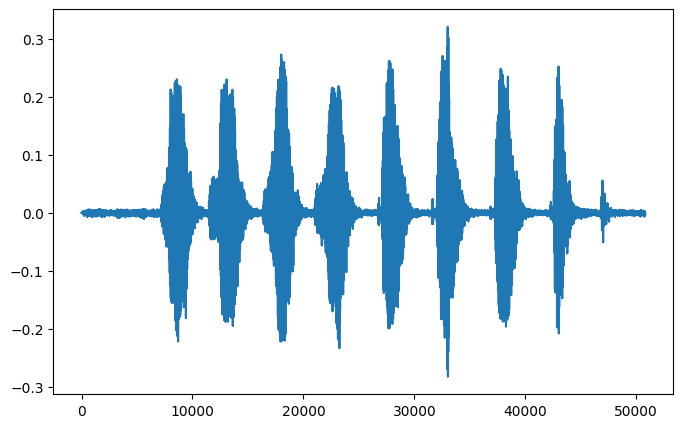

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
waveform, sample_rate, label = dataset[0]
plt.plot(waveform.flatten())
plt.show()

В PyTorch одномерная свертка задается аналогично двумерной: [torch.nn.Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html):

```
torch.nn.Conv1d(in_channels, out_channels,             kernel_size, stride=1,  padding=0, ...)
```

In [ ]:
from torch import nn

conv = nn.Conv1d(1, 16, 3, stride=2)
output = conv(waveform)
print(output.shape)

torch.Size([16, 25399])


Но такой сигнал чаще преобразуют в спектрограмму, а к ней уже можно применить 2D-свёртку:

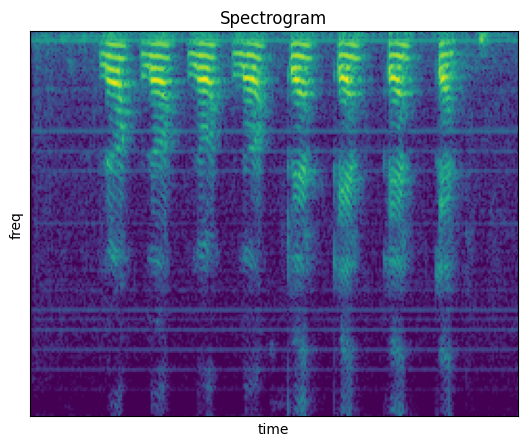

In [ ]:
from torchaudio.transforms import Spectrogram
import librosa

spec_obj = Spectrogram(power=2, center=True, pad_mode="reflect")
spec = spec_obj(waveform[0])

plt.figure(figsize=(7, 5))
plt.imshow(librosa.power_to_db(spec))
plt.title("Spectrogram")
plt.xlabel("time")
plt.ylabel("freq")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

Другим примером могут являться, например, спектрограммы растворов:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L06/s_spectr.png" width="500"></center>

<center><em>Source: <a href="https://github.com/EduNetArchive/Sarmanova_CD_HM_sensor">EduNet-archive: CD HM sensor</a></em></center>

Например, если мы воздействуем светом одной длины волны,
а фиксируем суммарную интенсивность излучения, то такие данные можно свернуть 1D-свёрткой

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L06/s_spectr2.png" width="700"></center>

<center><em>Source: <a href="https://github.com/EduNetArchive/Sarmanova_CD_HM_sensor">EduNet-archive: CD HM sensor</a></em></center>





Если мы можем зафиксировать отклик на разных длинах волн, то используем 2D-свёртку.

##### Дополнительная информация

Рассмотрим, как выглядит операция свертки в функциональном анализе.

Есть две различные функции, определяющие локальную "схожесть" функций $f(t)$ и $g(t)$:
- взаимнокорреляционная функция обозначается пятиконечной звездой <font size="8">$\large ⋆$</font> и определяет схожесть двух функций:
$$(f ⋆ g)(t)\stackrel{def}{=}  \int\limits_{-\infty}^{\infty}  f(\tau)g(t+\tau)d\tau$$
- свертка обозначается звездочкой (астериском) <font size="8">$*$</font> и определяет схожесть одной функции и "отраженной" другой функции:
$$\large(f * g)(t)\stackrel{def}{=}  \int\limits_{-\infty}^{\infty}  f(\tau)g(t-\tau)d\tau$$

Взаимная корреляция более интуитивно понятна: она представляет собой "наложение" шаблона на функцию, а свертка &mdash; "наложение" отраженного шаблона. Эти функции взаимосвязаны:
$$f(t) ⋆ g(t) = f(-t) * g(t)$$

Можно представить свертку как площадь произведения двух функций внутри скользящего окна, как на анимации ниже.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/1d_convolution.gif" width="700">

В машинном обучении под словом **convolution** как правило [подразумевают](https://glassboxmedicine.com/2019/07/26/convolution-vs-cross-correlation/) **взаимнокорреляционную функцию**, а не свертку. В реальности при обучении нейронной сети совершенно неважно, используется ли свертка или взаимнокорреляционная функция &mdash; они отличаются лишь порядком расположения весов внутри тензора ядра.

В случае дискретных величин для вычисления взаимной корреляции сигнал $f(t)$ поэлементно умножается со смещенным ядром $g(t)$, и результат суммируется:

$$\large(f \star g)(t) = f(1)g(t+1) + f(2)g(t+2) + f(3)g(t+3) + ...$$

Одномерная операция свертки используется для данных, имеющих последовательную структуру: текстов, аудиозаписей, цифровых сигналов. Как правило, такую структуру можно представить в виде изменения величины с течением времени.

Данные связаны в одном измерении — временном. Их тоже можно обработать при помощи свертки, но уже в одном измерении.

### Свертка через перемножение матриц

Проводить вычисления при помощи вложенных циклов малоэффективно. Но операцию свертки можно реализовать через матричное умножение, которое очень эффективно выполняется на GPU. Идею того, как это происходит, можно продемонстрировать на примере 1D-свертки. Будем сворачивать 1D-сигнал `input_1d` с 1D-фильтром `kernel_1d`. Воспользуемся операцией 1D-свертки из библиотеки NumPy:

In [ ]:
import numpy as np


input_1d = np.array([1, 2, 4, 5, 3, 0])
kernel_1d = np.array([5, 4])

out = np.convolve(
    input_1d,
    np.flip(kernel_1d),  # because real conv reverse order of elements
    mode="valid",
)

# 5*1 + 4*2 = 5 + 8   = 13
# 5*2 + 4*4 = 10 + 16 = 26
# 5*4 + 4*5 = 20 + 20 = 40
# 5*5 + 4*3 = 25 + 12 = 37
# 5*3 + 4*0 = 15 + 0  = 15

print(out)

[13 26 40 37 15]


После того, как мы отменили "переворот", выполнив `np.flip` и превратив свертку в взаимнокорреляционную функцию, результат совпал с ожидаемым. Восстановим последовательность действий по шагам:

**Шаг 1.**

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/matrix_conv1.png" width="400">

Перемножаем первые два входа на значения из ядра фильтра и суммируем их.

**Шаг 2**

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/matrix_conv2.png" width="400">

Сдвигаем фильтр и повторяем операцию.

...

**Шаг N**

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/matrix_conv3.png" width="400">

Если мы дополним фильтр нулями вот таким образом:

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/matrix_conv4.png" width="400">

То результат не поменяется.

Видно, что если скомбинировать дополненные нулями ядра в матрицу и транспонировать ее, то мы получим тот же результат, скалярно умножив входной вектор на эту матрицу.

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html
from scipy.sparse import diags


# Alternative to sparse_matrix = diags([5,4],[0,1],shape=(5, 6)).toarray()
output_shape = len(input_1d) - len(kernel_1d) + 1
sparse_matrix = diags(
    kernel_1d, [0, 1], shape=(output_shape, len(input_1d))  # diagonals positions
).toarray()

print(sparse_matrix)

[[5. 4. 0. 0. 0. 0.]
 [0. 5. 4. 0. 0. 0.]
 [0. 0. 5. 4. 0. 0.]
 [0. 0. 0. 5. 4. 0.]
 [0. 0. 0. 0. 5. 4.]]


In [ ]:
out2 = sparse_matrix.dot(input_1d)
print("Result ", out2)

Result  [13. 26. 40. 37. 15.]


<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/matrix_conv5.png" width="500">

Для двумерной свертки действует похожая логика, подробне можно прочесть здесь: [2D Convolution as a Matrix-Matrix Multiplication](https://www.baeldung.com/cs/convolution-matrix-multiplication)

И при получении градиентов это тоже работает: [Forward and Backward Convolution Passes as Matrix Multiplication](https://danieltakeshi.github.io/2019/03/09/conv-matmul/)


## 3D

Двумерная операция свертки, о которой мы много говорили, применяется для обработки данных, имеющих пространственную структуру, то есть тех данных, для которых играют роль взаимные расположения по двум осям. Совсем не обязательно, чтобы эти оси соответствовали высоте и ширине картинки. Например, одна ось может соответствовать координате сенсора в одномерной матрице, а вторая — времени получения информации с него.

Трёхмерная операция свертки используется, когда данные имеются три независимых "пространственных" компоненты. Простейшим примером являются видео: к двумерной структуре самих изображений добавляется координата времени.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/3d_convolution.png" width="600">





```
 torch.nn.Conv3d(in_channels,
                  out_channels,
                  kernel_size,
                  stride=1,
                  padding=0,
                  dilation=1,
                  groups=1,
                  bias=True,
                  padding_mode='zeros')

```



In [ ]:
import torch

# With cubic kernels and same stride
conv = nn.Conv3d(in_channels=16, out_channels=33, kernel_size=3, stride=2)

# non-square kernels with unequal stride and padding
conv = nn.Conv3d(
    in_channels=16,
    out_channels=33,
    kernel_size=(3, 5, 2),
    stride=(2, 1, 1),
    padding=(4, 2, 0),
)

input = torch.randn(20, 16, 10, 50, 100)
out = conv(input)

print("out shape: ", out.shape)

out shape:  torch.Size([20, 33, 8, 50, 99])


# Визуализация

Чтобы лучше понять, как работают сверточные сети, можно визуализировать карты активаций и веса фильтров свёртки.

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/what_hidden_layers.png" width="1000">

## Визуализация весов

Веса фильтров на первом слое легко визуализировать. И результат легко интерпретируется, так как у фильтров такое же количество каналов, как и у цветных изображений (3).

Ниже приведен пример того, как это можно сделать для обученной модели AlexNet из зоопарка моделей torchvision.

Чтобы понять, через какие свойства можно получить доступ к весам, выведем структуру модели

In [ ]:
from torchvision import models

alexnet = models.alexnet(weights="AlexNet_Weights.DEFAULT")
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 97.4MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Видно, что первый слой — это 0-й элемент контейнера features.
Веса хранятся в `weight.data`.

In [ ]:
weight_tensor = alexnet.features[0].weight.data  # extract weights
print("Weights shape", weight_tensor.shape)

Weights shape torch.Size([64, 3, 11, 11])


Чтобы отобразить все веса на одном изображении, воспользуемся вспомогательной функцией [make_grid](https://pytorch.org/vision/stable/generated/torchvision.utils.make_grid.html#make-grid) из [torchvision.utils](https://pytorch.org/vision/stable/utils.html).

На вход метод получает batch изображений (B x C x H x W) в формате torch.Tensor и визуализирует их в форме таблице.

In [ ]:
from torchvision import utils

img_grid = utils.make_grid(
    (weight_tensor + 1) / 2, pad_value=1
)  # combine weights from all channel into table, note remapping to (0,1) range
print("Output is CxHxW image", img_grid.shape)

Output is CxHxW image torch.Size([3, 106, 106])


Ее часто используют, чтобы отображать изображения в TensorBoard.

А чтобы отобразить получившуюся таблицу в блокноте средствами matplotlib, нам потребуется поменять порядок хранения данных, поместив каналы на первое место.

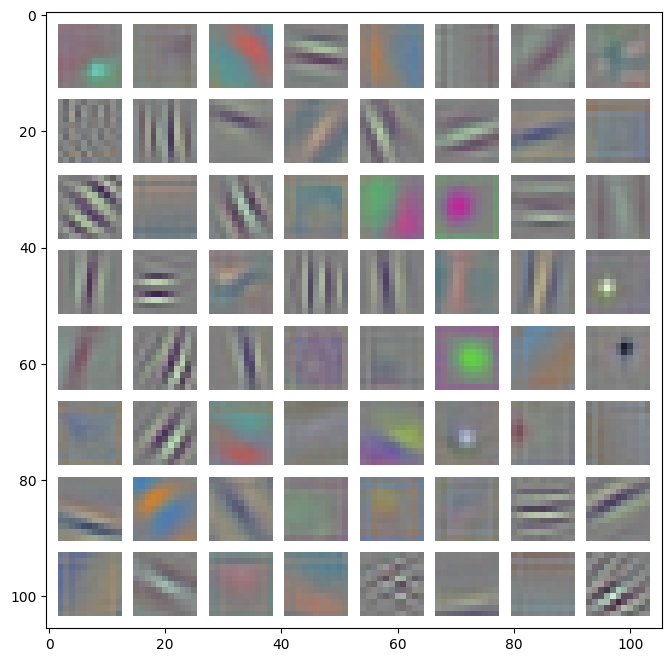

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(
    np.transpose(img_grid, (1, 2, 0))
)  # change channel order for compability with numpy & matplotlib
plt.show()

Видно, что модель научились улавливать простые геометрические формы: края под разными углами, точки того или иного цвета. Тем не менее, фильтры AlexNet'а оказались настолько большими, что частично захватили не только простую локальную информацию, но и сложные градиенты или решётки.


### Визуализация фильтров промежуточных слоев

К сожалению, выполнить ту же операцию для фильтров на скрытых слоях едва ли представляется разумным: в отличие от принятого трёхканального вида фильтров, который легко можно трактовать и визуализировать, фильтры поздних слоёв имеют гораздо больше каналов, что делает их удобное отображение практически невозможным. Пожалуй, единственным вариантом отображения является поканальное отображение весов, которое довольно сложно трактовать, в чём можно убедиться, взглянув на пример ниже.

**Higher Layer: Visualize Filter**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L06/weight_visualization.png" width="600"></center>

<center><em> We can visualize filters at higher layers, but not that interesting</em></center>

<center><em>Source: <a href="https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html">ConvNetJS CIFAR-10 example</a></em></center>

Визуализируем веса 2-го сверточного слоя AlexNet.
Слой доступен через `features[3] `

In [ ]:
weights_of_conv2_layer = alexnet.features[3].weight.data  # extract weights
print(weights_of_conv2_layer.shape)

torch.Size([192, 64, 5, 5])


В нем 192 фильтра, в каждом 64 ядра. Поэтому ограничимся первым фильтром и выведем все его ядра.

In [ ]:
first_filter_kernels = weights_of_conv2_layer[0]
print(first_filter_kernels.shape)

torch.Size([64, 5, 5])


Чтобы использовать `image_grid`, входной тензор должен иметь формат BxCxHxW.  Поэтому добавим размерность, соответствующую каналам:

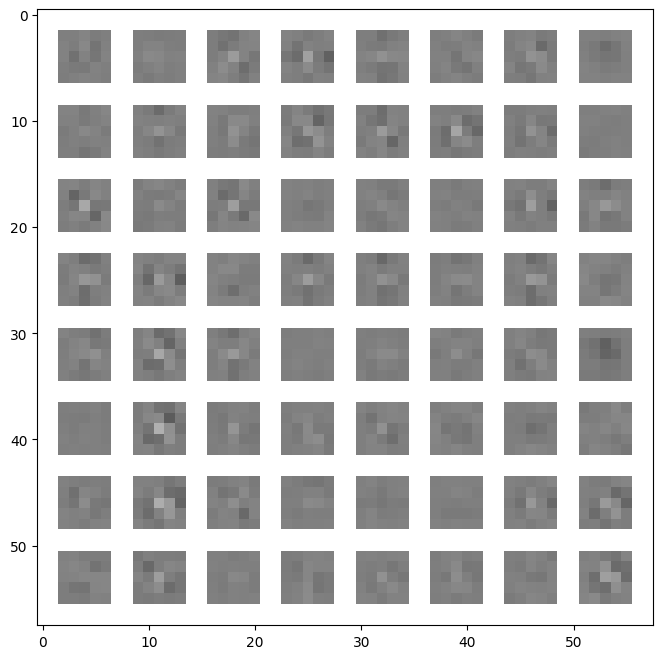

In [ ]:
img_grid = utils.make_grid(
    weights_of_conv2_layer[0].unsqueeze(1), pad_value=1  # add fake channel dim
)

plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(
    np.transpose((img_grid + 1) / 2, (1, 2, 0))
)  # change channel order for compability with numpy
plt.show()

Интерпретация такой визуализации довольно затруднительна, зато мы разобрались, как получать доступ к весам.

## Визуализация карт активаций

Наиболее очевидный метод визуализации заключается в том, чтобы показать активации сети во время прямого прохода. Для сетей ReLU активации обычно начинают выглядеть относительно сгущенными и плотными, но по мере развития обучения активации обычно становятся более редкими и локализованными.

На последних слоях свёрточной нейронной сети размеры рецептивных полей нейронов становятся сравнимы с размером исходного изображения, поэтому при визуализации их карт активации становится понятно, какие нейроны реагируют на какие части изображений.

К примеру, на изображении ниже активация выделенного нейрона достигнута благодаря пикселям, примерно соответствующим расположению лица человека, поэтому можно предположить, что он научился находить лица на изображении. Более подробно об этом можно почитать в статье [Understanding Neural Networks Through Deep Visualization](https://arxiv.org/abs/1506.06579).

**Visualizing Activations**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L06/visualization_activations.png" width="500"></center>

<center><em> conv5 feature map is $128\times13\times13$; visualize as $128$ $13\times13$ grayscale images</em></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf">Visualizing and Understanding</a></em></center>

В отличие от весов, карты активаций не сохраняются в памяти. Для того, чтобы получить к ним доступ, в PyTorch предусмотрен механизм под названием [Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks).

Благодаря ему можно получить доступ к выходам или входам слоя как при прямом, так и при обратном распространении сигнала через сеть.



Зарегистрируем свой hook. Он просто выведет в консоль размеры карты активации (выхода слоя).



In [ ]:
from torch import nn


def module_hook(module: nn.Module, input, output):  # For nn.Module objects only.
    print("Hi, i am hook_1 ! ", output.shape)  # activation_map


handle = alexnet.features[10].register_forward_hook(
    module_hook
)  # attach hook to last conv layer

Проверим, что он работает:

In [ ]:
import torch

out = alexnet(torch.randn(1, 3, 224, 224))

Hi, i am hook_1 !  torch.Size([1, 256, 13, 13])


Чтобы удалить hook, используйте метод `remove` дескриптора, который возвращает метод `register_forward_hook`:

In [ ]:
handle.remove()
out = alexnet(torch.randn(1, 3, 224, 224))

Вывода нет, hook отключился!

Теперь напишем hook, который выведет нам карту активации.
Так как на выходе данного слоя 256 каналов, выведем каждый отдельно, подав на вход `make_grid` тензор с 256 элементами.

Для этого потребуется:
* удалить batch-измерение;
* добавить измерение, имитирующее канал для картинок.




In [ ]:
def module_hook(module: nn.Module, input, output):
    # activation_map = output.squeeze(0).unsqueeze(1) # alternative solution
    activation_map = output.permute(1, 0, 2, 3)  # B <--> C
    print(activation_map.shape)
    img_grid = utils.make_grid(activation_map, pad_value=10, nrow=16)
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.imshow(
        np.transpose((img_grid.clamp(-1, 1) + 1) / 2, (1, 2, 0))
    )  # normalize to 0..1 range and change channel order for compability with numpy
    plt.show()


handle = alexnet.features[10].register_forward_hook(module_hook)





Чтобы карта активаций  была интерпретируема, надо использовать реальное изображение. Загрузим его:

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-web_dependencies/L06/fox.jpg'

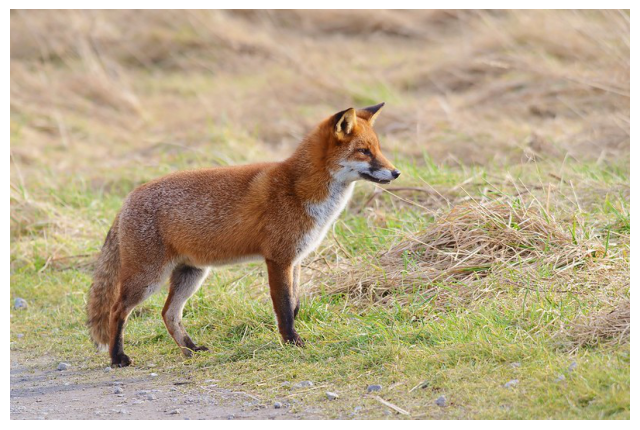

In [ ]:
from PIL import Image

img_fox = Image.open("fox.jpg")

plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(img_fox)
plt.axis("off")
plt.show()

Загрузим изображение, преобразуем в тензор и подадим на вход модели:

torch.Size([256, 1, 15, 15])


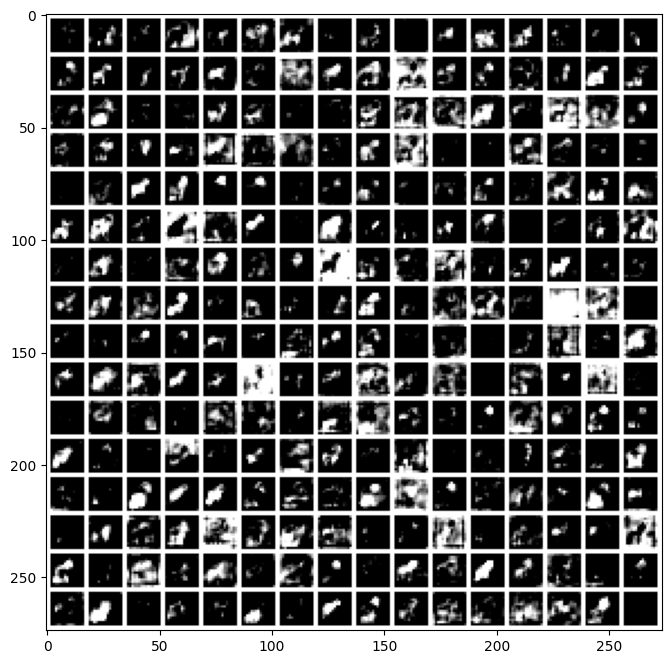

In [ ]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

tensor = transform(img_fox)
out = alexnet(tensor.unsqueeze(0))

Тут уже можно увидеть некоторые паттерны. Видно, что многие фильтры реагируют на лисицу.

Единственная опасная ловушка, которую можно легко заметить с помощью этой визуализации, заключается в том, что некоторые карты активации могут быть равны нулю для многих различных входов. Это может указывать на мертвые фильтры и может быть симптомом слишком высокой скорости обучения.

Отключим наш hook, чтобы он не мешал дальнейшим экспериментам

In [ ]:
handle.remove()

Существуют техники которые позволяют визуализировать паттерн на который лучше всего активируется конкретный нейрон. Они основаны на подсчете градиента не по весам а по входу(изображению) и его постепенной модификации.

Вот пример такой визуализации:

[Exploring Neural Networks with Activation Atlases](https://distill.pub/2019/activation-atlas/)

[Feature Visualization](https://distill.pub/2017/feature-visualization/)


## Feature extractor

Альтернативным способом понимания эффективности обучения сети является анализ карт активаций с последних слоёв нейронной сети. Поскольку в процессе работы нейросети создаются промежуточные представления, имеющие меньшую размерность, весь процесс представляет из себя проектирование данных в пространство меньшей размерности. Новое представление может быть использовано для решения различных задач не только с помощью линейных слоёв нейросети, но и с помощью других методов машинного обучения.

В следующих примерах мы будем использовать представление, полученное на последнем скрытом слое свёрточной нейронной сети.

**Последний слой**

<img src ="https://edunet.kea.su/repo/EduNet-content/L06/out/feature_extractor.png" width="1000">

Чтобы убедиться в полезности полученных представлений, выполним поиск ближайшего соседа для изображения в исходном виде, пиксельном пространстве. В результате будут получены изображения, не всегда относящиеся к тому же классу, что и исходное изображение.

Если же мы используем предобученную свёрточную нейронную сеть для получения представлений изображений в более низкой размерности и затем применим алгоритм поиска соседей, то "близко" друг к другу окажутся изображения, принадлежащие одному классу, даже если есть визуально более похожие изображения из иных классов, так как фон и прочие неважные части изображения имеют меньшее влияние на представление. Успешное извлечение признаков отображает успешное обучение модели. Один из вариантов выполнения кластеризации изображений — кластеризация промежуточных представлений свёрточных нейронных сетей.

**Последний слой: ближайшие соседи**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L06/last_layer_knn.jpg" width="900"></center>

<center><em>Source: <a href="https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf">ImageNet Classification with Deep Convolutional Neural Networks</a></em></center>

Загрузим одну из наиболее легких моделей, чтобы не переключаться на GPU:

In [ ]:
from torchvision.models import mobilenet_v3_small

mobile_net = mobilenet_v3_small(weights="IMAGENET1K_V1")
tmp = mobile_net.eval()
print(mobile_net)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:01<00:00, 6.73MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Посмотрим на ее структуру и заменим два последних слоя заглушками.

`nn.Identity()` — класс, который возвращает вход без изменений.

In [ ]:
mobile_net.classifier[1] = nn.Identity()
mobile_net.classifier[2] = nn.Identity()
mobile_net.classifier[3] = nn.Identity()

Загрузим датасет

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


torch.manual_seed(42)

transform = Compose(
    [Resize(224), ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

testset = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)
train, test, _ = random_split(testset, [512, 128, 9360])
train_loader = DataLoader(train, batch_size=128, shuffle=False, drop_last=True)


def get_embeddings(loader):
    embeddings = []
    labels = []
    for img, label in tqdm(loader):
        emb = mobile_net(img)
        embeddings.append(emb.detach())
        labels.append(label)
    return (
        torch.stack(embeddings).reshape(-1, 1024).numpy(),
        torch.stack(labels).flatten().numpy(),
    )

100%|██████████| 170498071/170498071 [00:10<00:00, 15641783.86it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10


Добавим функцию, которая сохраняет выходы измененной модели в массиве, а также возвращает метки классов:

In [ ]:
def get_embeddings(loader):
    embeddings = []
    labels = []
    for img, label in tqdm(loader):
        emb = mobile_net(img)
        embeddings.append(emb.detach())
        labels.append(label)
    embeddings = torch.stack(embeddings).reshape(-1, 1024).numpy()
    labels = torch.stack(labels).flatten().numpy()
    return embeddings, labels

Превратим картинки в векторы признаков:

In [ ]:
%%time
x, y = get_embeddings(train_loader)

100%|██████████| 4/4 [00:08<00:00,  2.14s/it]

CPU times: user 4.47 s, sys: 4.08 s, total: 8.56 s
Wall time: 8.61 s


Теперь у нас есть 512 векторов по 1024 значения в каждом и 512 меток классов

In [ ]:
print(x.shape, y.shape)

(512, 1024) (512,)


"Обучим" на них k-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x, y)

KNeighborsClassifier()

Получим вектора-признаки (embeddings) для тестовых кариинок

In [ ]:
%%time

test_loader = DataLoader(test, batch_size=32, shuffle=False, drop_last=True)
test_emb, gt_labels = get_embeddings(test_loader)

100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

CPU times: user 1.15 s, sys: 49.1 ms, total: 1.2 s
Wall time: 1.2 s


Получаем предсказания и считаем accuracy:

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = neigh.predict(test_emb)

accuracy = accuracy_score(gt_labels, y_pred)
print("k-NN accuracy", accuracy)

k-NN accuracy 0.6953125


Как видим, активации на последних слоях сети достаточно информативны

# Практические рекомендации

*   Используйте [готовые модели](https://pytorch.org/vision/stable/models.html).
*   Используйте фильтры $1 \times 1 $.
*   Чтобы уменьшить пространственные размеры, используйте свертку со `stride = 2`.
*   Сохраняйте логи и следите за ходом обучения при помощи инструментов [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) и [Weights&Biases](https://wandb.ai/site).
*   Отлаживайте код на на части датасета:


In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from IPython.display import clear_output

dataset = MNIST(root="./MNIST", train=True, download=True)

clear_output()

debug_train, debug_val, _ = random_split(dataset, [5000, 1000, 54000])
print("Debug train len:", len(debug_train))

Debug train len: 5000


<font size="6">Полезные материалы</font>

[Визуализация принципов работы свертки](https://www.youtube.com/watch?v=eMXuk97NeSI&list=PLZDCDMGmelH-pHt-Ij0nImVrOmj8DYKbB&index=1)

[Convolution & FFT](https://www.youtube.com/watch?v=KuXjwB4LzSA)

[Теорема свертки](https://www.reg.ru/blog/svyortka-v-deep-learning-prostymi-slovami)

[A guide to convolution arithmetic for deep
learning](https://arxiv.org/pdf/1603.07285v1.pdf)

[YouTube: But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA)

[YouTube: Fundamental Algorithm of Convolution in Neural Networks](https://www.youtube.com/watch?v=eMXuk97NeSI&list=PLZDCDMGmelH-pHt-Ij0nImVrOmj8DYKbB)


